In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
import glob
import os
import re
import rasterio
import geopandas as gpd
from rasterio.mask import geometry_mask
from sklearn.preprocessing import LabelEncoder

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(all_image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in all_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(all_image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})


In [3]:
print("Total images:", len(all_image_paths))
print("Images paired with shapefiles:", len(file_pairs))
print("Images with general shapefiles:", sum(1 for _, (gen, _) in file_pairs.items() if gen is not None))
print("Images with walrus shapefiles:", sum(1 for _, (_, wal) in file_pairs.items() if wal is not None))


Total images: 30
Images paired with shapefiles: 20
Images with general shapefiles: 14
Images with walrus shapefiles: 10


In [4]:
for island in set(extract_island_and_date(os.path.basename(img))[0] for img in all_image_paths):
    island_pairs = {img: shp for img, shp in file_pairs.items() if extract_island_and_date(os.path.basename(img))[0] == island}
    print(f"\n{island}:")
    print(f"  Total images: {sum(1 for img in all_image_paths if extract_island_and_date(os.path.basename(img))[0] == island)}")
    print(f"  Paired images: {len(island_pairs)}")
    print(f"  With general shapefiles: {sum(1 for _, (gen, _) in island_pairs.items() if gen is not None)}")
    print(f"  With walrus shapefiles: {sum(1 for _, (_, wal) in island_pairs.items() if wal is not None)}")

# Step 2: Compute total number of pixels in each class
class_counts = dataset['labels'].value_counts()
print("Total number of pixels in each class:")
print(class_counts)


tor:
  Total images: 9
  Paired images: 8
  With general shapefiles: 4
  With walrus shapefiles: 5

pool:
  Total images: 1
  Paired images: 0
  With general shapefiles: 0
  With walrus shapefiles: 0

pal:
  Total images: 8
  Paired images: 3
  With general shapefiles: 3
  With walrus shapefiles: 0

moff:
  Total images: 1
  Paired images: 1
  With general shapefiles: 1
  With walrus shapefiles: 0

buch:
  Total images: 6
  Paired images: 6
  With general shapefiles: 4
  With walrus shapefiles: 3

sars:
  Total images: 5
  Paired images: 2
  With general shapefiles: 2
  With walrus shapefiles: 2
Total number of pixels in each class:
labels
ocean           779288
ice             300231
rock             92856
freshwater       40251
walrus_mixed      1309
walrus_pure        222
Name: count, dtype: int64


In [8]:
# Define a color map for the labels
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Define band wavelength ranges and descriptive names
band_wavelengths = {
    'Coastal Blue': (431, 452),  # Coastal Blue
    'Blue': (465, 515),  # Blue
    'Green 1': (513, 549),  # Green 1
    'Green': (547, 583),  # Green
    'Yellow': (600, 620),  # Yellow
    'Red': (630, 680),  # Red
    'Red Edge': (697, 713),  # Red Edge
    'NIR': (845, 885)   # NIR
}

New number of pixels after undersampling:
labels
ocean           222
rock            222
freshwater      222
ice             222
walrus_pure     222
walrus_mixed    222
Name: count, dtype: int64


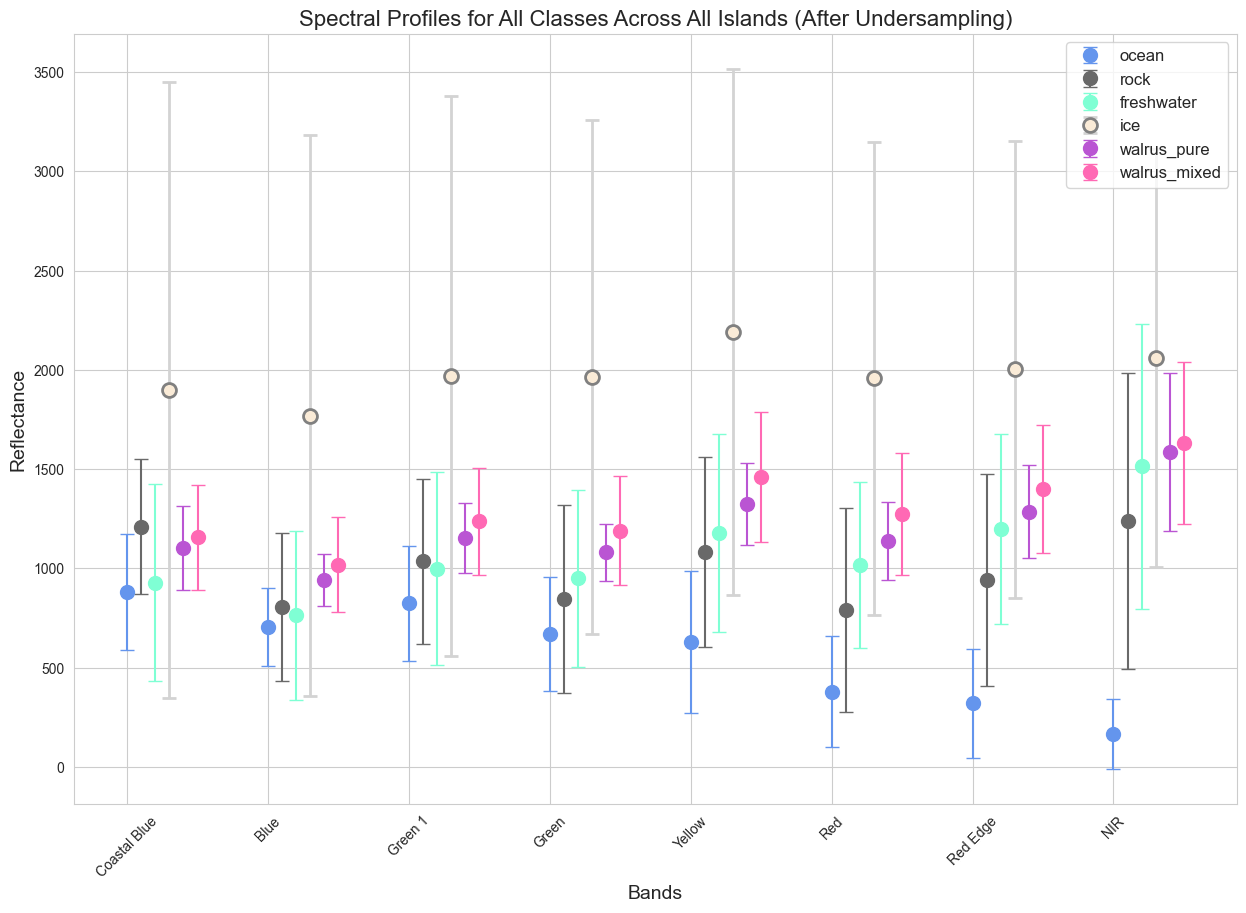

In [13]:
# Step 5: Undersample larger classes
unique_labels = dataset['labels'].unique()
desired_counts = {
    'walrus_mixed': 222,
    'walrus_pure': 222,
    'ocean': 222,
    'rock': 222,
    'freshwater': 222,
    'ice': 222
}

undersampled_data = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label]
    if label in desired_counts:
        if len(class_data) > desired_counts[label]:
            undersampled_data.append(resample(class_data, replace=False, n_samples=desired_counts[label]))
        else:
            undersampled_data.append(class_data)
    else:
        undersampled_data.append(class_data)

undersampled_dataset = pd.concat(undersampled_data)

new_class_counts = undersampled_dataset['labels'].value_counts()
print("New number of pixels after undersampling:")
print(new_class_counts)

# Calculate mean and std profiles for undersampled data
unique_labels = undersampled_dataset['labels'].unique()
bands = np.arange(8)  # Assuming there are 8 bands as per the original data structure
mean_profiles = []
std_profiles = []

for label in unique_labels:
    class_data = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].values
    mean_profiles.append(class_data.mean(axis=0))
    std_profiles.append(class_data.std(axis=0))

mean_profiles = np.array(mean_profiles)
std_profiles = np.array(std_profiles)

# Staggering factor
staggering_factor = 0.1

plt.figure(figsize=(15, 10))
for class_index, class_label in enumerate(unique_labels):
    mean = mean_profiles[class_index]
    std = std_profiles[class_index]
    offset = class_index * staggering_factor
    if class_label == 'ice':
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color='antiquewhite', fmt='o', capsize=5, markersize=10, ecolor='lightgrey', elinewidth=2, markeredgewidth=2, markeredgecolor='grey')
    else:
        plt.errorbar(bands + offset, mean, yerr=std, label=class_label, color=label_colors.get(class_label, 'black'), fmt='o', capsize=5, markersize=10)

# Set custom tick labels with descriptive names
band_names = list(band_wavelengths.keys())
plt.xticks(ticks=bands, labels=band_names, rotation=45)

plt.xlabel('Bands', fontsize=14)
plt.ylabel('Reflectance', fontsize=14)
plt.title('Spectral Profiles for All Classes Across All Islands (After Undersampling)', fontsize=16)
plt.legend(fontsize=12)
plt.show()


In [14]:
print("Original dataset shape:", dataset.shape)
print("Undersampled dataset shape:", undersampled_dataset.shape)

Original dataset shape: (1214157, 11)
Undersampled dataset shape: (1332, 11)


In [15]:
for label in unique_labels:
    original_mean = dataset[dataset['labels'] == label].iloc[:, :8].mean().values
    undersampled_mean = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].mean().values
    print(f"Class: {label}")
    print("Original mean:", original_mean)
    print("Undersampled mean:", undersampled_mean)
    print()

Class: ocean
Original mean: [893.91098413 706.64512478 837.74593732 677.47597936 648.18193531
 396.55954795 333.4120954  168.94038533]
Undersampled mean: [881.23873874 703.87387387 822.77927928 668.36936937 628.67117117
 379.12162162 319.68018018 164.18918919]

Class: rock
Original mean: [1219.79760059  799.33399026 1028.49451839  818.69014388 1063.63552167
  760.92993452  894.42664987 1155.32419014]
Undersampled mean: [1209.77927928  805.97297297 1034.34234234  844.28378378 1082.39189189
  790.36486486  941.52702703 1239.84684685]

Class: freshwater
Original mean: [ 952.8862637   772.7887009  1012.96318104  956.73180791 1193.52781297
 1017.73210603 1179.74209336 1444.91759211]
Undersampled mean: [ 928.0045045   763.73423423  998.97747748  950.21621622 1177.04504505
 1014.54054054 1199.18468468 1512.8963964 ]
Class: ice
Original mean: [1994.58282789 1858.51160939 2066.2924215  2044.05017137 2271.98384244
 2058.79010828 2097.76431814 2126.79215671]
Undersampled mean: [1898.72972973 1768

In [16]:
import pandas as pd
import numpy as np

band_names = ['Coast_blue', 'Blue', 'Green1', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

def format_means(means):
    return [f"{m:.4f}" for m in means]

comparison_data = []

for label in unique_labels:
    original_mean = dataset[dataset['labels'] == label].iloc[:, :8].mean().values
    undersampled_mean = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].mean().values
    
    comparison_data.append({
        'Class': label,
        'Dataset': 'Original',
        **dict(zip(band_names, format_means(original_mean)))
    })
    comparison_data.append({
        'Class': label,
        'Dataset': 'Undersampled',
        **dict(zip(band_names, format_means(undersampled_mean)))
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index(['Class', 'Dataset'])

print(comparison_df)

# Calculate and display the differences
diff_data = []
for label in unique_labels:
    original_mean = dataset[dataset['labels'] == label].iloc[:, :8].mean().values
    undersampled_mean = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].mean().values
    diff = undersampled_mean - original_mean
    
    diff_data.append({
        'Class': label,
        'Dataset': 'Difference',
        **dict(zip(band_names, format_means(diff)))
    })

diff_df = pd.DataFrame(diff_data)
diff_df = diff_df.set_index(['Class', 'Dataset'])

print("\nDifferences (Undersampled - Original):")
print(diff_df)

# Calculate and display the percent differences
percent_diff_data = []
for label in unique_labels:
    original_mean = dataset[dataset['labels'] == label].iloc[:, :8].mean().values
    undersampled_mean = undersampled_dataset[undersampled_dataset['labels'] == label].iloc[:, :8].mean().values
    percent_diff = ((undersampled_mean - original_mean) / original_mean) * 100
    
    percent_diff_data.append({
        'Class': label,
        'Dataset': 'Percent Difference',
        **dict(zip(band_names, [f"{pd:.2f}%" for pd in percent_diff]))
    })

percent_diff_df = pd.DataFrame(percent_diff_data)
percent_diff_df = percent_diff_df.set_index(['Class', 'Dataset'])

print("\nPercent Differences:")
print(percent_diff_df)

                          Coast_blue       Blue     Green1      Green  \
Class        Dataset                                                    
ocean        Original       893.9110   706.6451   837.7459   677.4760   
             Undersampled   881.2387   703.8739   822.7793   668.3694   
rock         Original      1219.7976   799.3340  1028.4945   818.6901   
             Undersampled  1209.7793   805.9730  1034.3423   844.2838   
freshwater   Original       952.8863   772.7887  1012.9632   956.7318   
             Undersampled   928.0045   763.7342   998.9775   950.2162   
ice          Original      1994.5828  1858.5116  2066.2924  2044.0502   
             Undersampled  1898.7297  1768.2252  1970.1982  1963.4505   
walrus_pure  Original      1101.8468   943.2703  1151.6306  1079.7523   
             Undersampled  1101.8468   943.2703  1151.6306  1079.7523   
walrus_mixed Original      1145.9916  1029.9832  1236.2078  1195.4026   
             Undersampled  1156.7568  1019.1126  12

In [17]:
import numpy as np
from sklearn.utils import resample

# Function to extract island name from file path
def extract_island(file_path):
    return extract_island_and_date(os.path.basename(file_path))[0]

# Desired number of pixels for undersampling
desired_counts = {
    'walrus_mixed': 1309,
    'walrus_pure': 222,
    'ocean': 4000,
    'rock': 3000,
    'freshwater': 2000,
    'ice': 4000
}

# Step 5: Undersample larger classes while preserving island representation
undersampled_data = []

for label in unique_labels:
    class_data = dataset[dataset['labels'] == label]
    islands = class_data['image_name'].apply(extract_island).unique()
    
    if label in desired_counts:
        if len(class_data) > desired_counts[label]:
            # Calculate samples per island
            samples_per_island = max(1, desired_counts[label] // len(islands))
            
            island_samples = []
            for island in islands:
                island_data = class_data[class_data['image_name'].apply(extract_island) == island]
                if len(island_data) > samples_per_island:
                    island_samples.append(resample(island_data, replace=False, n_samples=samples_per_island))
                else:
                    island_samples.append(island_data)
            
            # Combine samples from all islands
            combined_samples = pd.concat(island_samples)
            
            # If we still have more samples than desired, perform a final resample
            if len(combined_samples) > desired_counts[label]:
                combined_samples = resample(combined_samples, replace=False, n_samples=desired_counts[label])
            
            undersampled_data.append(combined_samples)
        else:
            undersampled_data.append(class_data)
    else:
        undersampled_data.append(class_data)

undersampled_dataset = pd.concat(undersampled_data)

new_class_counts = undersampled_dataset['labels'].value_counts()
print("New number of pixels after undersampling:")
print(new_class_counts)

# Print island representation for each class
for label in unique_labels:
    class_data = undersampled_dataset[undersampled_dataset['labels'] == label]
    islands = class_data['image_name'].apply(extract_island).unique()
    print(f"\nClass: {label}")
    print(f"Number of islands: {len(islands)}")
    print(f"Islands: {', '.join(islands)}")
    print(f"Total pixels: {len(class_data)}")

New number of pixels after undersampling:
labels
ocean           4000
ice             4000
rock            3000
freshwater      1576
walrus_mixed    1309
walrus_pure      222
Name: count, dtype: int64

Class: ocean
Number of islands: 5
Islands: buch, moff, pal, sars, tor
Total pixels: 4000

Class: rock
Number of islands: 3
Islands: buch, pal, tor
Total pixels: 3000

Class: freshwater
Number of islands: 3
Islands: buch, moff, tor
Total pixels: 1576

Class: ice
Number of islands: 5
Islands: buch, moff, pal, sars, tor
Total pixels: 4000

Class: walrus_pure
Number of islands: 3
Islands: buch, pal, tor
Total pixels: 222

Class: walrus_mixed
Number of islands: 5
Islands: buch, moff, pal, sars, tor
Total pixels: 1309
